In [1]:
import pandas as pd
import numpy as np
import pickle
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df_books = pd.read_csv("Books.csv", sep=";", encoding="latin-1", on_bad_lines="skip")
df_book_ratings = pd.read_csv(
    "Book-Ratings-Subset.csv", sep=";", encoding="latin-1", on_bad_lines="skip"
)
df_users = pd.read_csv("Users.csv", sep=";", encoding="latin-1", on_bad_lines="skip")

C:\Users\anshu\AppData\Local\Temp\ipykernel_18228\3879346936.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_books = pd.read_csv('Books.csv', sep=';', encoding='latin-1', on_bad_lines='skip')


In [3]:
df_books.columns = [col.strip() for col in df_books.columns]
df_book_ratings.columns = [col.strip() for col in df_book_ratings.columns]
df_users.columns = [col.strip() for col in df_users.columns]

In [4]:
# Display the shape of the dataframes
print(f"Shape of df_books: {df_books.shape}")
print(f"Shape of df_book_ratings: {df_book_ratings.shape}")
print(f"Shape of df_users: {df_users.shape}")

Shape of df_books: (271379, 8)
Shape of df_book_ratings: (77756, 3)
Shape of df_users: (278858, 3)


C:\Users\anshu\AppData\Local\Temp\ipykernel_18228\1062614672.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_ratings.index, y=top_ratings.values, palette='viridis')


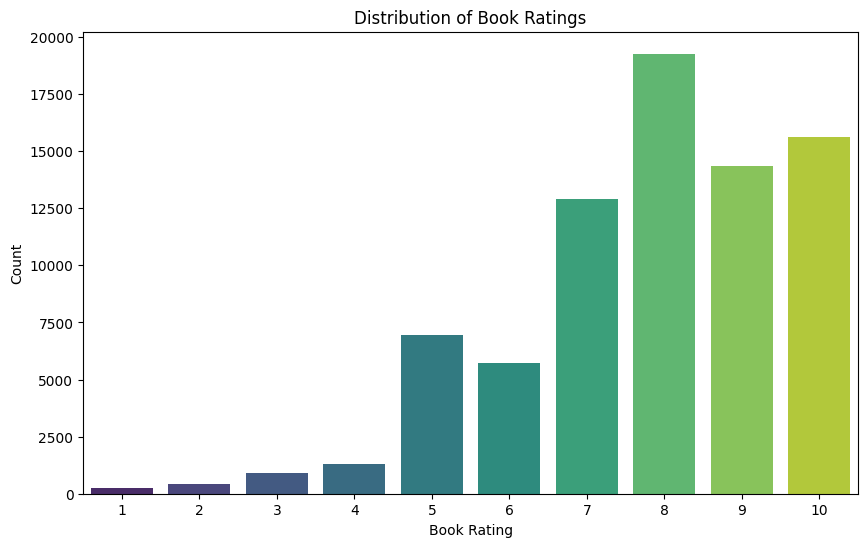

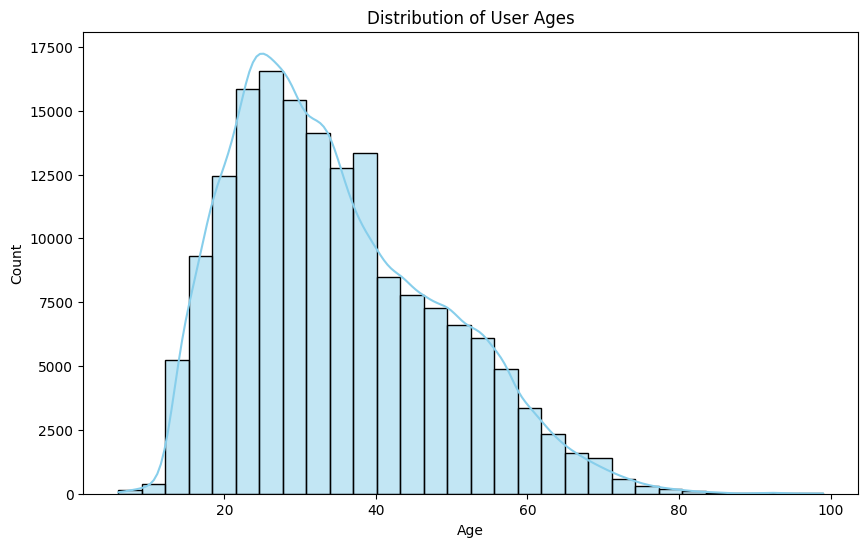

C:\Users\anshu\AppData\Local\Temp\ipykernel_18228\1062614672.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_publishers.values, y=top_publishers.index, palette='magma')


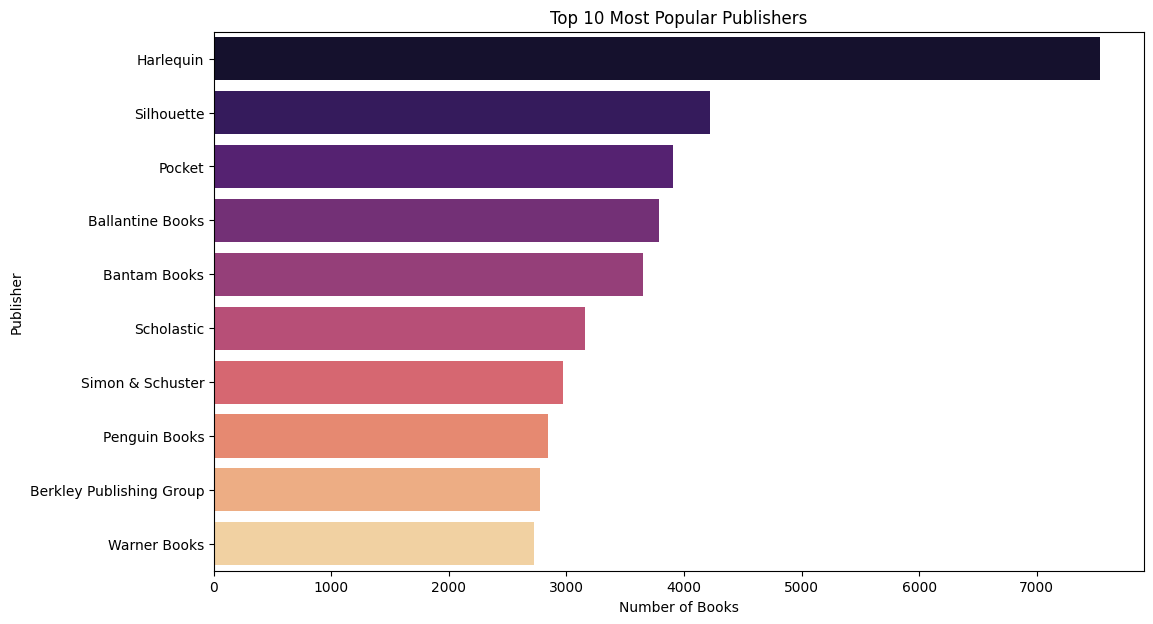

In [ ]:
# Plot a bar chart of the top 10 most frequent book ratings
plt.figure(figsize=(10, 6))
top_ratings = df_book_ratings["Book-Rating"].value_counts().sort_index()
sns.barplot(x=top_ratings.index, y=top_ratings.values, palette="viridis")
plt.title("Distribution of Book Ratings")
plt.xlabel("Book Rating")
plt.ylabel("Count")
plt.show()

# Plot a histogram of user ages
plt.figure(figsize=(10, 6))
# Filter out invalid ages (e.g., ages > 100 or < 5) for a cleaner plot
valid_ages = df_users[(df_users["Age"] > 5) & (df_users["Age"] < 100)]["Age"]
sns.histplot(valid_ages, bins=30, kde=True, color="skyblue")
plt.title("Distribution of User Ages")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

# Plot a bar chart of the top 10 most popular publishers
plt.figure(figsize=(12, 7))
top_publishers = df_books["Publisher"].value_counts().head(10)
sns.barplot(x=top_publishers.values, y=top_publishers.index, palette="magma")
plt.title("Top 10 Most Popular Publishers")
plt.xlabel("Number of Books")
plt.ylabel("Publisher")
plt.show()

In [ ]:
# --- Filter and Merge Data for Model Training ---
# To create a more robust model, we will filter for users and books with a significant number of ratings.
# Filter out users who have rated fewer than 5 books (adjusted for smaller dataset)
user_ratings_count = df_book_ratings["User-ID"].value_counts()
active_users = user_ratings_count[user_ratings_count >= 5].index
filtered_ratings = df_book_ratings[df_book_ratings["User-ID"].isin(active_users)]

# Filter out books that have been rated by fewer than 5 users (adjusted for smaller dataset)
book_ratings_count = filtered_ratings["ISBN"].value_counts()
popular_books = book_ratings_count[book_ratings_count >= 5].index
final_ratings = filtered_ratings[filtered_ratings["ISBN"].isin(popular_books)]

# Merge the ratings with the book information
model_data = pd.merge(final_ratings, df_books, on="ISBN")

In [ ]:
# Create a user-item matrix from the merged data
# We'll use a pivot table to create a sparse matrix
user_item_matrix = model_data.pivot_table(
    index="Book-Title", columns="User-ID", values="Book-Rating"
).fillna(0)

# Check if the matrix is empty before fitting the model
if user_item_matrix.empty:
    print(
        "Error: The filtered data resulted in an empty user-item matrix. Try adjusting the filtering thresholds."
    )
    exit()

# Convert the pandas DataFrame to a SciPy Compressed Sparse Row matrix
# This is more memory-efficient and required by the NearestNeighbors model
user_item_sparse_matrix = csr_matrix(user_item_matrix.values)

# Instantiate and fit the NearestNeighbors model for item-based collaborative filtering
# We will use 'cosine' similarity to find books that are most similar to each other
model_knn = NearestNeighbors(metric="cosine", algorithm="brute")
model_knn.fit(user_item_sparse_matrix)

,n_neighbors,5
,radius,1.0
,algorithm,'brute'
,leaf_size,30
,metric,'cosine'
,p,2
,metric_params,None
,n_jobs,None


In [ ]:
with open("model_knn.pkl", "wb") as f:
    pickle.dump(model_knn, f)

with open("user_item_matrix.pkl", "wb") as f:
    pickle.dump(user_item_matrix, f)

# We also need to save the book data
with open("df_books.pkl", "wb") as f:
    pickle.dump(df_books, f)